In [798]:
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.tokenize import word_tokenize,sent_tokenize

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

from itertools import combinations
from collections import defaultdict

from simhash import Simhash, SimhashIndex

%matplotlib inline

In [237]:
nyu = pd.read_csv("C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/nyu_tweets.csv", encoding="ISO-8859-1")

In [234]:
uchicago = pd.read_csv("C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/uchicago_tweets.csv", encoding="ISO-8859-1")

C:\Users\garim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,4,6,7,9,13,14,15,16,17,18,19,21,22,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [235]:
cornell = pd.read_csv("C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/cornell_tweets.csv", encoding="ISO-8859-1")

In [236]:
columbia = pd.read_csv("C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/columbia_tweets.csv", encoding="ISO-8859-1")

In [6]:
uchicago.columns

Index(['text', 'created_at', 'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_user_id', 'is_quote_status', 'possibly_sensitive',
       'quote_count', 'lang', 'reply_count', 'retweet_count', 'timestamp_ms',
       'coordinates.coordinates', 'entities.hashtags', 'place.country',
       'place.country_code', 'place.full_name', 'place.id', 'place.place_type',
       'user.id', 'user.screen_name', 'user.verified', 'user.followers_count',
       'user.listed_count', 'user.friends_count', 'user.favourites_count',
       'user.statuses_count', 'user.created_at', 'user.lang'],
      dtype='object')

In [32]:
uchicago.shape

(188001, 30)

In [9]:
cornell.shape

(10727, 30)

In [10]:
nyu.shape

(32733, 30)

In [12]:
columbia.shape

(17851, 30)

In [238]:
uchicago['nullval'] =  uchicago.isnull().sum(axis=1)
nyu['nullval'] =  nyu.isnull().sum(axis=1)
columbia['nullval'] =  columbia.isnull().sum(axis=1)
cornell['nullval'] =  cornell.isnull().sum(axis=1)

In [38]:
print(len(uchicago.columns), uchicago['nullval'].max())

31 29


In [42]:
uchicago  = uchicago.dropna(axis = 0, thresh=10)
nyu  = nyu.dropna(axis = 0, thresh=10)

In [43]:
nyu.shape

(32731, 31)

In [17]:
print(len(nyu.columns), nyu['nullval'].max())

31 29


In [18]:
print(len(cornell.columns), cornell['nullval'].max())

31 11


In [19]:
print(len(columbia.columns), columbia['nullval'].max())

31 11


In [245]:
cornell['text'].isnull().sum()

0

**Identify the most prolific / influential Twitter users by message volume or retweets**

Since the retweets column does not havegreater than zero counts for any record, I will use the 'RT' keyword and '@' reference from 'text' column to calculate the number of retweets for a particular screen name 

In [239]:
uchicago['rt_flag'] = uchicago['text'].str.contains('RT @', na = 0)*1
nyu['rt_flag'] = nyu['text'].str.contains('RT @', na = 0)*1
cornell['rt_flag'] = cornell['text'].str.contains('RT @', na = 0)*1
columbia['rt_flag'] = columbia['text'].str.contains('RT @', na = 0)*1

In [73]:
uchicago.text.str.find(":").max()

158.0

In [74]:
nyu.text.str.find(":").max()

146.0

In [75]:
cornell.text.str.find(":").max()

172.0

In [76]:
columbia.text.str.find(":").max()

164.0

In [240]:
uchicago['rt_owner'] = uchicago.text.str.slice(4,172 )*uchicago.rt_flag
nyu['rt_owner'] = nyu.text.str.slice(4,172 )*nyu.rt_flag
cornell['rt_owner'] = cornell.text.str.slice(4,172 )*cornell.rt_flag
columbia['rt_owner'] = columbia.text.str.slice(4,172 )*columbia.rt_flag

In [241]:
uchicago.loc[uchicago['rt_flag']==1,'rt_owner'] = uchicago.loc[uchicago['rt_flag']==1,'rt_owner'].str.split(":").apply(lambda x: x[0])
nyu.loc[nyu['rt_flag']==1,'rt_owner'] = nyu.loc[nyu['rt_flag']==1,'rt_owner'].str.split(":").apply(lambda x: x[0])
cornell.loc[cornell['rt_flag']==1,'rt_owner'] = cornell.loc[cornell['rt_flag']==1,'rt_owner'].str.split(":").apply(lambda x: x[0])
columbia.loc[columbia['rt_flag']==1,'rt_owner'] = columbia.loc[columbia['rt_flag']==1,'rt_owner'].str.split(":").apply(lambda x: x[0])

In [242]:
cornell.rt_owner[:10]

0      RebeccaCokley
1                   
2            Cornell
3      RebeccaCokley
4                   
5        cornellnews
6        cornellnews
7        cornellnews
8                   
9    CornellCALSDean
Name: rt_owner, dtype: object

**User activity summary: Number of messages**

In [864]:
uchicago_tweeters = pd.DataFrame(uchicago.groupby(by=['user.screen_name'], sort=False)['user.followers_count' , 'user.listed_count' , 'user.friends_count' , 'user.favourites_count' , 'user.statuses_count'].mean().sort_values(by = ['user.followers_count'], ascending = False))
uchicago_tweeters.head(50)

,user.followers_count,user.listed_count,user.friends_count,user.favourites_count,user.statuses_count
user.screen_name,,,,,
TheEconomist,2.340225e+07,110920.000000,1.580000e+02,305.000000,139970.000000
WSJ,1.559673e+07,108869.000000,1.106000e+03,1287.000000,235878.000000
Forbes,1.387196e+07,53635.166667,5.596167e+03,5754.000000,168663.666667
AP,1.170814e+07,88976.000000,7.228000e+03,722.000000,190204.000000
HuffPost,1.091418e+07,84379.000000,5.705000e+03,980.000000,490240.000000
XHNews,1.088599e+07,10199.500000,5.600000e+01,0.000000,97875.000000
ndtv,1.026523e+07,11509.000000,2.000000e+01,0.000000,396078.000000
NewYorker,8.495948e+06,62896.800000,4.164000e+02,1717.400000,71815.400000
NPR,7.369748e+06,64879.000000,7.234600e+04,2328.500000,138850.500000


In [865]:
nyu_tweeters = pd.DataFrame(nyu.groupby(by=['user.screen_name'], sort=False)['user.followers_count' , 'user.listed_count' , 'user.friends_count' , 'user.favourites_count' , 'user.statuses_count'].sum().sort_values(by = ['user.followers_count'], ascending = False))
nyu_tweeters.head(50)

,user.followers_count,user.listed_count,user.friends_count,user.favourites_count,user.statuses_count
user.screen_name,,,,,
Reuters,19045897.0,112639.0,1063.0,812.0,224128.0
realmadriden,18312497.0,18268.0,104.0,224.0,68418.0
UberFacts,14559560.0,18198.0,1.0,1092.0,145920.0
FIFAcom,11615780.0,19836.0,831.0,138.0,66786.0
BabyAnimalsPic,10397581.0,4424.0,0.0,390.0,6431.0
NewYorker,8355549.0,62565.0,414.0,1617.0,67476.0
SexLowkey,7402505.0,26500.0,36234.0,343481.0,255689.0
guardian,7210604.0,56854.0,1108.0,148.0,441908.0
Notebook,6301035.0,13909.0,245.0,406.0,53559.0


In [880]:
columbia_tweeters = pd.DataFrame(columbia.groupby(by=['user.screen_name'], sort=False)['user.followers_count' , 'user.listed_count' , 'user.friends_count' , 'user.favourites_count' , 'user.statuses_count'].sum().sort_values(by = ['user.statuses_count'], ascending = False))
columbia_tweeters.head(50)

,user.followers_count,user.listed_count,user.friends_count,user.favourites_count,user.statuses_count
user.screen_name,,,,,
CMasden7,4921,151,5306,146253,6890248
t_hisashi,9730,1681,1100,134,6629901
davealvord164,95956,448,119636,3314229,5741564
ElliotVanOrman,61833,5877,22850,4427051,5317566
rashidaldosari,7206,1507,162,938,3865976
PMorris153,6180,309,1860,278725,3067038
sunnyherring1,66892,5913,65344,34485,3034346
dvdinfatuation,269425,11000,227325,66632,2772032
JohnnyVCaffine,15170,6019,6897,21677,2448508


In [88]:
cornell_tweeters = pd.DataFrame(cornell.groupby(by=['user.screen_name'], sort=False)['user.followers_count' , 'user.listed_count' , 'user.friends_count' , 'user.favourites_count' , 'user.statuses_count'].sum().sort_values(by = ['user.statuses_count'], ascending = False))
cornell_tweeters.head(50)

,user.followers_count,user.listed_count,user.friends_count,user.favourites_count,user.statuses_count
user.screen_name,,,,,
NPazderski,32042.0,6022.0,28758.0,4331282.0,4206359.0
rjber15,15678.0,9106.0,4791.0,139080.0,3404560.0
CMasden7,2034.0,6.0,2482.0,40920.0,2644711.0
HowardStrauber,122908.0,63833.0,111880.0,437363.0,2491887.0
RobRe62,37028.0,15332.0,5366.0,28236.0,1925873.0
Nuevomedio,11286.0,5284.0,0.0,3604.0,1564215.0
iheretanqmo,4148.0,128.0,1028.0,112152.0,1296289.0
ArkangelScrap,39278.0,20922.0,27025.0,29062.0,1233634.0
marekingu,10777.0,782.0,11883.0,354435.0,1230962.0


In [ ]:
**User activity summary: Number of retweets**

In [93]:
uchicago_rt = pd.DataFrame(uchicago.groupby(by=['rt_owner'], sort=False)['rt_flag'].sum()).sort_values(by = ['rt_flag'], ascending = False)
uchicago_rt.head(50)

,rt_flag
rt_owner,
UChicago,5411
NobelPrize,4040
uchicagogsu,3550
sofiaorden,2961
davidaxelrod,2245
haileysecretary,1840
JustinWolfers,1751
ChicagoMaroons,1467
bestcolleges_,1404


In [94]:
nyu_rt = pd.DataFrame(nyu.groupby(by=['rt_owner'], sort=False)['rt_flag'].sum()).sort_values(by = ['rt_flag'], ascending = False)
nyu_rt.head(50)

,rt_flag
rt_owner,
itscollegebabes,10349
Aronwana,487
StFrexit,431
nyuniversity,359
realmadriden,335
ScholarshipsGL,319
UberFacts,267
humanprogress,262
COLLEGEBADDlES,249


In [96]:
cornell_rt = pd.DataFrame(cornell.groupby(by=['rt_owner'], sort=False)['rt_flag'].sum()).sort_values(by = ['rt_flag'], ascending = False)
cornell_rt.head(50)

,rt_flag
rt_owner,
Cornell,3170
CornellWBrooks,501
cornellsun,475
MikeQuindazzi,186
SayItLikeJay,184
TheMarkPantano,176
cornellnews,114
CIA,114
CornellGSU,103


In [95]:
columbia_rt = pd.DataFrame(columbia.groupby(by=['rt_owner'], sort=False)['rt_flag'].sum()).sort_values(by = ['rt_flag'], ascending = False)
columbia_rt.head(50)

,rt_flag
rt_owner,
shamuskhan,2339
ColumbiaBugle,544
Columbia,372
columbiatribune,351
ColumbiaChi,303
WSJ,279
YESNetwork,184
JuddLegum,183
FoxNews,173


Where are these autors located?

In [546]:
coord = uchicago['coordinates.coordinates'].dropna()

In [519]:
x = [lat[1579],long[1579]]
x

[-87.60040946, 41.79003304]

In [549]:
lat = coord.apply(lambda x: x.split(',')[0])
lat = list(lat.str.slice(1,len(lat)).astype('float'))

long = coord.apply(lambda x: x.split(',')[1])

In [550]:
long = long.apply(lambda x: x.replace(']','')).astype('float')
long =list(long) 

In [573]:
type(long)

list

In [560]:
location = pd.concat([pd.DataFrame(lat), pd.DataFrame(long)], axis=1)
locationlist = location.values.tolist()

In [199]:
import folium

In [585]:
coordnyu = nyu['coordinates.coordinates'].dropna()
latnyu = coordnyu.apply(lambda x: x.split(',')[0])
latnyu = list(latnyu.str.slice(1,len(latnyu)).astype('float'))

longnyu = coordnyu.apply(lambda x: x.split(',')[1])

longnyu = longnyu.apply(lambda x: x.replace(']','')).astype('float')
longnyu =list(longnyu) 

coordcol = columbia['coordinates.coordinates'].dropna()
latcol = coordcol.apply(lambda x: x.split(',')[0])
latcol = list(latcol.str.slice(1,len(latcol)).astype('float'))

longcol = coordcol.apply(lambda x: x.split(',')[1])

longcol = longcol.apply(lambda x: x.replace(']','')).astype('float')
longcol =list(longcol) 

coordcorr = cornell['coordinates.coordinates'].dropna()
latcorr = coordcorr.apply(lambda x: x.split(',')[0])
latcorr = list(latcorr.str.slice(1,len(latcorr)).astype('float'))

longcorr = coordcorr.apply(lambda x: x.split(',')[1])

longcorr = longcorr.apply(lambda x: x.replace(']','')).astype('float')
longcorr =list(longcorr) 


In [586]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[41.81, -87.62], tiles='cartodbdark_matter', zoom_start=5)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(coord)):
    folium.Marker([long[point],lat[point]],popup ="UChicago", icon=folium.Icon(color='blue', icon_color='white', icon='cloud', angle=0)).add_to(marker_cluster)

In [587]:
marker_cluster.save( 'C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/map_uchicago.html')

In [589]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[41.81, -87.62], tiles='cartodbdark_matter', zoom_start=5)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(coordnyu)):
    folium.Marker([longnyu[point],latnyu[point]],popup ="NYU", icon=folium.Icon(color='blue', icon_color='white', icon='cloud', angle=0)).add_to(marker_cluster)

marker_cluster.save( 'C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/map_NYU.html')

In [594]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[41.81, -87.62], tiles='cartodbdark_matter', zoom_start=5)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(coordcorr)):
    folium.Marker([longcorr[point],latcorr[point]],popup ="Cornell", icon=folium.Icon(color='blue', icon_color='white', icon='cloud', angle=0)).add_to(marker_cluster)

marker_cluster.save( 'C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/map_Cornell.html')

In [596]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[41.81, -87.62], tiles='cartodbdark_matter', zoom_start=5)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(coordcol)):
    folium.Marker([longcol[point],latcol[point]],popup ="Columbia", icon=folium.Icon(color='blue', icon_color='white', icon='cloud', angle=0)).add_to(marker_cluster)

marker_cluster.save( 'C:/Users/garim/Documents/Quarter3/Bigdata/Project/Files/map_Columbia.html')

What distinguishes UChicago authors vs. authors who tweet about other universities?

In [ ]:
import re

In [247]:
hash_uchicago = uchicago['text'].apply(lambda x: re.findall(r"#(\w+)", x ))
hash_nyu = nyu['text'].apply(lambda x: re.findall(r"#(\w+)", x ))
hash_columbia = columbia['text'].apply(lambda x: re.findall(r"#(\w+)", x ))
hash_cornell = cornell['text'].apply(lambda x: re.findall(r"#(\w+)", x ))


In [248]:
hash_cornell

0                                            []
1                                   [education]
2                                 [Eclipse2017]
3                                            []
4                                            []
5                                            []
6                                            []
7                                            []
8                                            []
9                                           [1]
10                                           []
11                                           []
12                                           []
13                                           []
14                                           []
15                                           []
16                       [ewopinion, education]
17                                 [Cornell, 7]
18                                 [Cornell, 7]
19                                 [Cornell, 7]
20                                      

In [252]:
uchicago['text'] = uchicago['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
uchicago['text'] = uchicago['text'].apply(lambda x: re.sub('  ', ' ', x))
uchicago['text'][1]

'the four uchicago dress senses business casual (25% unrepentant stemlord (20% gay ascetic (10% seinfeld extra (45%'

In [256]:
nyu['text'] = nyu['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
nyu['text'] = nyu['text'].apply(lambda x: re.sub('  ', ' ', x))
nyu['text'][1]

'black lives matter syllabus - taught and designed by frank leon roberts new york university https//tco/wwgofztzl3'

In [257]:
cornell['text'] = cornell['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
cornell['text'] = cornell['text'].apply(lambda x: re.sub('  ', ' ', x))
cornell['text'][1]

'the latest university startup daily https//tco/ehtc8imf1i thanks to cornellmba grantmac89 luis__doporto education'

In [258]:
columbia['text'] = columbia['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
columbia['text'] = columbia['text'].apply(lambda x: re.sub('  ', ' ', x))
columbia['text'][1]

'rt columbiatribune mizzou to rent dorm rooms on football weekends https//tco/uyw8tbb1gc'

**UChicago Tweets**

In [407]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ["https", "www", "mtf33zuqex","tco", "university", "chicago", "uchicago", "rt", " ", "-", "|", "nyuniversity", "nyu", "ny", "cornell", "new", "york", "columbia", "plz"]
stopwords.extend(newStopWords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [370]:
wordlist = uchicago['text'].str.split(' ')

wordlist = (list(wordlist))

In [390]:
hastuc = list(hash_uchicago)

In [392]:
hastuc = [y for x in hastuc for y in x]
hastuc[0:10]

['PaulSereno',
 'histology',
 'anagensis',
 'dinosaurs',
 'thursdaythought',
 'PaulSereno',
 'histology',
 'anagensis',
 'dinosaurs',
 'UChicago']

In [371]:
#flatten the lists
flattened_list = [y for x in wordlist for y in x]
flattened_list[0:10]

['non-uchicago',
 'people',
 'ignore',
 'this',
 'tweet\nthe',
 'iop',
 'isnt',
 'worth',
 'it',
 'without']

In [342]:
from collections import Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [396]:
filtered_words = [w for w in flattened_list if not w in stopwords]
filtered_words = [w for w in filtered_words if w.isalpha()]

a = Counter([x.lower() for y in filtered_words for x in y.split()])
b = (a.most_common())
makeaframe1 = pd.DataFrame(b)
makeaframe1.columns = ['Words', 'Frequency']


In [398]:
makeaframe1.head(30)

,Words,Frequency
0,help,33884
1,professor,19919
2,said,18047
3,social,17611
4,friedman,16943
5,milton,16923
6,famously,16813
7,homeworkhelp,16803
8,law,9238
9,students,8115


In [394]:
filtered_words = [w for w in hastuc if not w in stopwords]
filtered_words = [w for w in hastuc if w.isalpha()]

a = Counter([x.lower() for y in filtered_words for x in y.split()])
b = (a.most_common())
makeaframe = pd.DataFrame(b)
makeaframe.columns = ['Words', 'Frequency']
makeaframe

,Words,Frequency
0,help,32771
1,homeworkhelp,16803
2,uchicago,9284
3,law,2858
4,linguistics,1263
5,yesgsu,1251
6,middleeasternstudies,1246
7,theblackellewoods,1228
8,whatlikeiâ,1228
9,lastyear,1155


In [389]:
#Create your bigrams or trigrams
bgs = nltk.bigrams(filtered_words)
tgs = nltk.trigrams(filtered_words)


#compute frequency distribution for all the bigrams in the text
fdist_2 = nltk.FreqDist(bgs)
fdist_3 = nltk.FreqDist(tgs)


fdist_2_df = pd.DataFrame(fdist_2.most_common(),
                    columns=['Word', 'Frequency'])

fdist_3_df = pd.DataFrame(fdist_3.most_common(),
                    columns=['Word', 'Frequency'])


In [383]:
fgs = nltk.ngrams(filtered_words,4)
fdist_4 = nltk.FreqDist(fgs)
fdist_4_df = pd.DataFrame(fdist_4.most_common(),
                    columns=['Word', 'Frequency'])

In [867]:
fdist_2_df.head(50)

,Word,Frequency
0,"(help, help)",32767
1,"(milton, friedman)",16911
2,"(professor, milton)",16803
3,"(friedman, famously)",16803
4,"(famously, said)",16803
5,"(said, social)",16803
6,"(social, homeworkhelp)",16803
7,"(homeworkhelp, professor)",16802
8,"(awarded, richard)",4530
9,"(richard, h)",4380


In [395]:
fdist_2_df.head(30)

,Word,Frequency
0,"(help, help)",32767
1,"(milton, friedman)",16911
2,"(professor, milton)",16803
3,"(friedman, famously)",16803
4,"(famously, said)",16803
5,"(said, social)",16803
6,"(social, homeworkhelp)",16803
7,"(homeworkhelp, professor)",16802
8,"(awarded, richard)",4530
9,"(richard, h)",4380


In [381]:
fdist_3_df.head(30)

,Word,Frequency
0,"(help, help, help)",32766
1,"(professor, milton, friedman)",16803
2,"(milton, friedman, famously)",16803
3,"(friedman, famously, said)",16803
4,"(famously, said, social)",16803
5,"(said, social, homeworkhelp)",16803
6,"(social, homeworkhelp, professor)",16802
7,"(homeworkhelp, professor, milton)",16802
8,"(richard, h, thaler)",4349
9,"(prize, economic, sciences)",3924


**NYU Tweets**

In [408]:
wordlist2 = nyu['text'].str.split(' ')

wordlist2 = (list(wordlist2))

hastnyu = list(hash_nyu)

hastnyu = [y for x in hastnyu for y in x]


#flatten the lists
flattened_list2 = [y for x in wordlist2 for y in x]

filtered_words2 = [w for w in flattened_list2 if not w in stopwords]
filtered_words2 = [w for w in filtered_words2 if w.isalpha()]

a = Counter([x.lower() for y in filtered_words2 for x in y.split()])
b = (a.most_common())
makeaframe2 = pd.DataFrame(b)
makeaframe2.columns = ['Words', 'Frequency']

filtered_words2 = [w for w in hastnyu if not w in stopwords]
filtered_words2 = [w for w in hastnyu if w.isalpha()]

a = Counter([x.lower() for y in filtered_words2 for x in y.split()])
b = (a.most_common())
makeaframe2hc = pd.DataFrame(b)
makeaframe2hc.columns = ['Words', 'Frequency']

In [413]:
makeaframe2.head(50)

,Words,Frequency
0,itscollegebabes,10374
1,expel,1999
2,animal,1989
3,slaughterer,1977
4,sign,1907
5,accepted,1271
6,school,1092
7,professor,1006
8,harvard,998
9,via,831


In [412]:
makeaframe2hc.head(50)

,Words,Frequency
0,halamadrid,341
1,affirmativeaction,238
2,rmcwc,220
3,endjewishprivilege,177
4,nyu,176
5,jobs,150
6,pwd,146
7,vets,146
8,newyork,68
9,projectsiege,62


**Columbia Tweets**

In [480]:
wordlisttest = columbia['text'].str.split(' ')
wordlist3 = pd.Series([x for x in columbia['text'] if x.lower().find("columbiachi")<0])
wordlist3 = pd.Series([x for x in wordlist3 if x.lower().find("british")<0])
wordlist3 = pd.Series([x for x in wordlist3 if x.lower().find("canada")<0]).str.split(' ')

In [481]:
len(wordlist3)

16793

In [482]:
wordlist3 = list(wordlist3)

hastcol = list(hash_columbia)

hastcol = [y for x in hastcol for y in x]


#flatten the lists
flattened_list3 = [y for x in wordlist3 for y in x]

filtered_words3 = [w for w in flattened_list3 if not w in stopwords]
filtered_words3 = [w for w in filtered_words3 if w.isalpha()]

a = Counter([x.lower() for y in filtered_words3 for x in y.split()])
b = (a.most_common())
makeaframe3 = pd.DataFrame(b)
makeaframe3.columns = ['Words', 'Frequency']

filtered_words3 = [w for w in hastcol if not w in stopwords]
filtered_words3 = [w for w in hastcol if w.isalpha()]

a = Counter([x.lower() for y in filtered_words3 for x in y.split()])
b = (a.most_common())
makeaframe3hc = pd.DataFrame(b)
makeaframe3hc.columns = ['Words', 'Frequency']

In [483]:
makeaframe3.head(50)

,Words,Frequency
0,devon,4688
1,amp,3684
2,today,2707
3,student,2564
4,gun,2465
5,columbiasoc,2373
6,violence,2372
7,kind,2353
8,brilliant,2352
9,model,2351


In [484]:
makeaframe3hc.head(50)

,Words,Frequency
0,divestfromhate,248
1,chicago,178
2,mba,165
3,mooc,146
4,princeton,133
5,idliketoteach,124
6,studentveterans,118
7,columbia,115
8,harvard,112
9,universitystudies,90


In [430]:
'@ColumbiaChi' not in ['@ColumbiaChi', 'hello']

False

**Cornell hashtags**

In [485]:
wordlist5 = cornell['text'].str.split(' ')

wordlist5 = (list(wordlist5))

hastcor = list(hash_cornell)

hastcor = [y for x in hastcor for y in x]


#flatten the lists
flattened_list5 = [y for x in wordlist5 for y in x]

filtered_words5 = [w for w in flattened_list5 if not w in stopwords]
filtered_words5 = [w for w in filtered_words5 if w.isalpha()]

a = Counter([x.lower() for y in filtered_words5 for x in y.split()])
b = (a.most_common())
makeaframe5 = pd.DataFrame(b)
makeaframe5.columns = ['Words', 'Frequency']

filtered_words5 = [w for w in hastcor if not w in stopwords]
filtered_words5 = [w for w in hastcor if w.isalpha()]

a = Counter([x.lower() for y in filtered_words5 for x in y.split()])
b = (a.most_common())
makeaframe5hc = pd.DataFrame(b)
makeaframe5hc.columns = ['Words', 'Frequency']

In [486]:
makeaframe5.head(50)

,Words,Frequency
0,mission,2957
1,academic,2954
2,public,2951
3,discourse,2946
4,values,2943
5,civic,2943
6,essential,2942
7,promotes,2941
8,engagement,2941
9,critical,2940


In [487]:
makeaframe5hc.head(50)

,Words,Frequency
0,robotic,258
1,augmentedreality,203
2,breaking,195
3,obama,77
4,gmos,76
5,pr,75
6,cornell,61
7,ar,59
8,womenshistorymonthâ,58
9,clapback,58


In [488]:
#Create your bigrams or trigrams
bgs5 = nltk.bigrams(filtered_words5)
tgs5 = nltk.trigrams(filtered_words5)


#compute frequency distribution for all the bigrams in the text
fdist5_2 = nltk.FreqDist(bgs5)
fdist5_3 = nltk.FreqDist(tgs5)


fdist5_2_df = pd.DataFrame(fdist5_2.most_common(),
                    columns=['Word', 'Frequency'])

fdist5_3_df = pd.DataFrame(fdist5_3.most_common(),
                    columns=['Word', 'Frequency'])


In [489]:
fdist5_2_df

,Word,Frequency
0,"(AugmentedReality, Robotic)",203
1,"(Robotic, AugmentedReality)",167
2,"(BREAKING, BREAKING)",165
3,"(PR, GMOs)",75
4,"(WomensHistoryMonthÂ, Clapback)",58
5,"(AR, robotic)",52
6,"(GMO, papaya)",40
7,"(GMOs, PR)",36
8,"(HateCrime, Obama)",30
9,"(Obama, Obama)",27


**Timelines of the tweets**

In [599]:
uchicago.head(1)

,text,created_at,favorite_count,id,in_reply_to_screen_name,in_reply_to_user_id,is_quote_status,possibly_sensitive,quote_count,lang,...,user.listed_count,user.friends_count,user.favourites_count,user.statuses_count,user.created_at,user.lang,nullval,rt_flag,rt_owner,tweetos
0,non-uchicago people ignore this tweet\nthe iop...,Thu Jun 22 23:28:13 +0000 2017,0.0,8.780319e+17,NaN,NaN,False,False,NaN,en,...,54.0,390.0,10430.0,5739.0,Sun Apr 10 21:22:34 +0000 2016,en,10,0,,non-uchicago


In [600]:
import datetime

In [609]:
uchicago['date'] = pd.to_datetime(uchicago['created_at']).dt.date

In [610]:
uchicago['date'][:5]

0    2017-06-22
1    2017-06-22
2    2017-06-22
3    2017-06-22
4    2017-06-22
Name: date, dtype: object

In [611]:
nyu['date'] = pd.to_datetime(nyu['created_at']).dt.date
cornell['date'] = pd.to_datetime(cornell['created_at']).dt.date
columbia['date'] = pd.to_datetime(columbia['created_at']).dt.date

In [617]:
uc_time = uchicago.groupby('date',as_index=False)['text'].count()

print(uc_time['text'].max(),uc_time['text'].mean())

6725 472.40955631399316


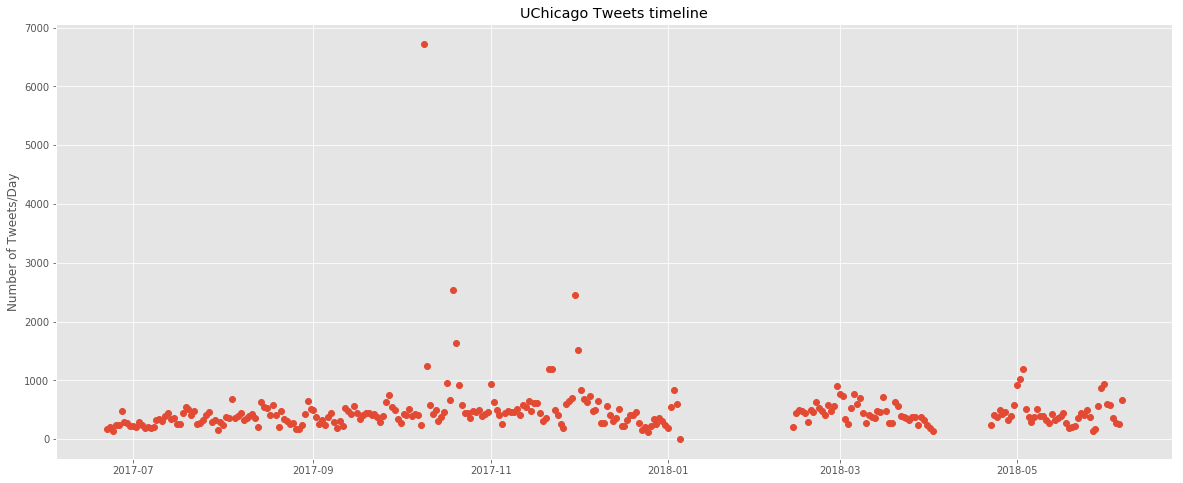

In [655]:
uc_time = uchicago.groupby('date',as_index=False)['text'].count()
plt.figure(figsize = (20,8))
uc_time.columns = ['date', 'UChicago']

plt.plot_date(matplotlib.dates.date2num(uc_time['date']),uc_time['UChicago'])
plt.ylabel("Number of Tweets/Day")
plt.title("UChicago Tweets timeline")

plt.show()

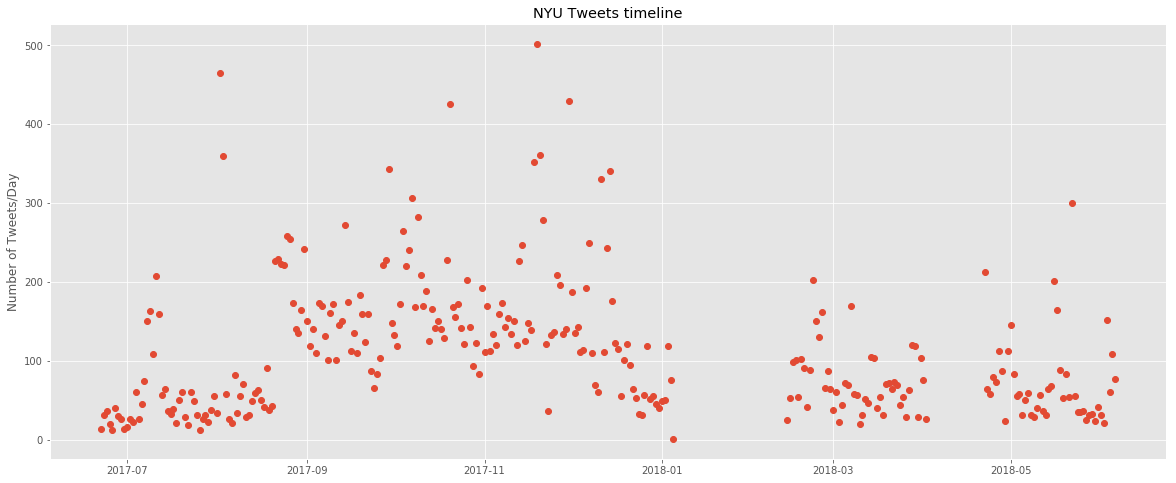

In [654]:
nyu_time = nyu.groupby('date',as_index=False)['text'].count()
nyu_time.columns = ['date', 'NYU']
plt.figure(figsize = (20,8))

plt.plot_date(matplotlib.dates.date2num(nyu_time['date']),nyu_time['NYU'])
plt.ylabel("Number of Tweets/Day")
plt.title("NYU Tweets timeline")

plt.show()

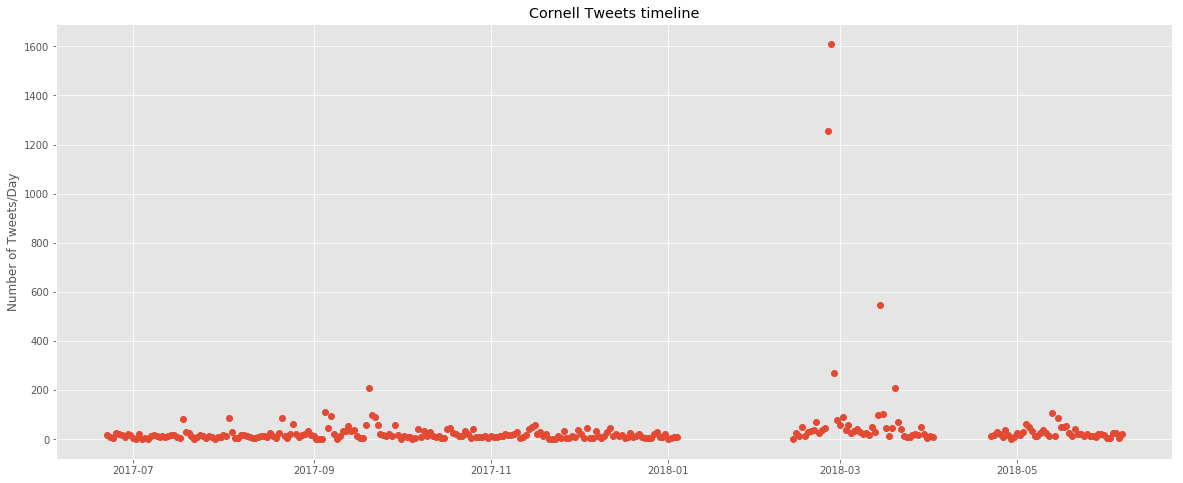

In [656]:
cornell_time = cornell.groupby('date',as_index=False)['text'].count()
plt.figure(figsize = (20,8))
cornell_time.columns = ['date', 'Cornell']

plt.plot_date(matplotlib.dates.date2num(cornell_time['date']),cornell_time['Cornell'])
plt.ylabel("Number of Tweets/Day")
plt.title("Cornell Tweets timeline")

plt.show()

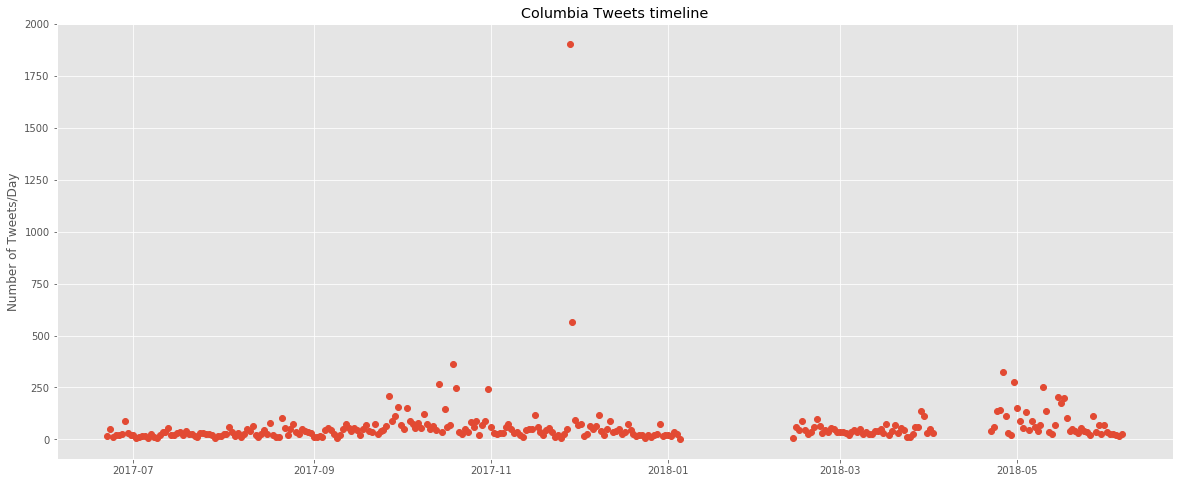

In [657]:
columbia_time = columbia.groupby('date',as_index=False)['text'].count()
plt.figure(figsize = (20,8))
columbia_time.columns = ['date', 'Columbia']

plt.plot_date(matplotlib.dates.date2num(columbia_time['date']),columbia_time['Columbia'])
plt.ylabel("Number of Tweets/Day")
plt.title("Columbia Tweets timeline")

plt.show()

In [664]:
tiemdata = uc_time.merge(nyu_time,on='date', how = 'outer').merge(cornell_time,on='date', how = 'outer').merge(columbia_time,on='date', how = 'outer')

In [669]:
tiemdata.head()

,date,UChicago,NYU,Cornell,Columbia
0,2017-06-22,168,14,19.0,15
1,2017-06-23,208,32,11.0,48
2,2017-06-24,145,37,6.0,12
3,2017-06-25,245,20,26.0,23
4,2017-06-26,241,12,23.0,20


(0, 3000)

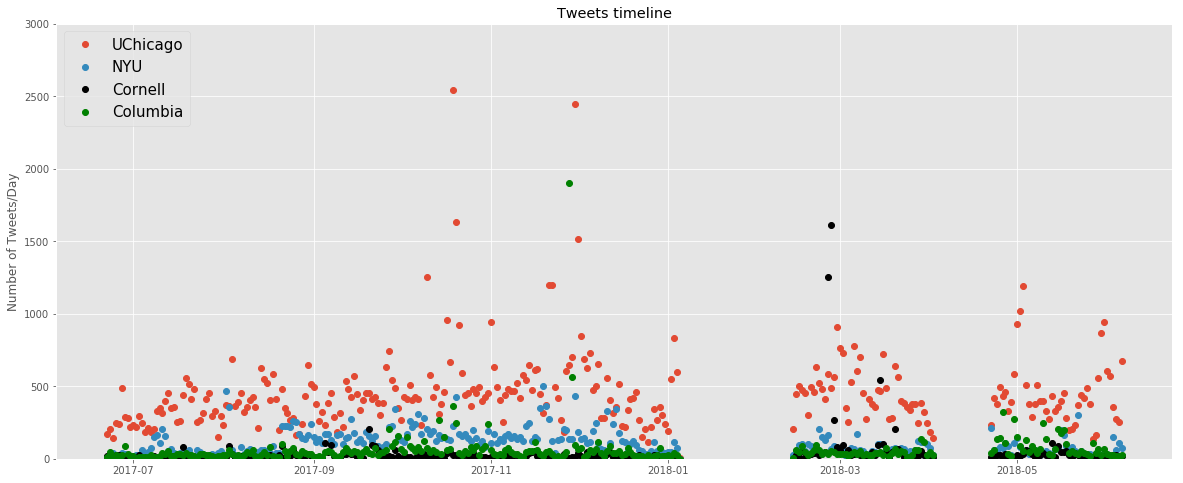

In [699]:
plt.figure(figsize = (20,8))

plt.plot_date(matplotlib.dates.date2num(tiemdata['date']),tiemdata['UChicago'])
plt.plot_date(matplotlib.dates.date2num(tiemdata['date']),tiemdata['NYU'])
plt.plot_date(matplotlib.dates.date2num(tiemdata['date']),tiemdata['Cornell'], color = "black")
plt.plot_date(matplotlib.dates.date2num(tiemdata['date']),tiemdata['Columbia'], color = "green")
plt.ylabel("Number of Tweets/Day")
plt.title("Tweets timeline")
plt.legend(loc='upper left',prop={'size': 15})
plt.gca().set_ylim([0,3000])

In [ ]:
Similarity of Tweets UChicago

In [788]:
def jaccard_similarity_words(text1, text2,n):

    text1_list = [y for x in text1.str.split() for y in x]
    text2_list = [y for x in text2.str.split() for y in x]
    
    #filtered_words1 = [w for w in text1_list if not w in stopwords]
    #filtered_words2 = [w for w in text2_list if w.isalpha()]
    
    doc1_grams = nltk.ngrams(text1_list,n)
    doc2_grams = nltk.ngrams(text2_list,n)

    doc1 = []
    doc2 = []

    for gram in doc1_grams:
        doc1.append(gram)

    for gram in doc2_grams:
        doc2.append(gram)

    intersection = len(list(set(doc1).intersection(set(doc2))))
    union = len(set(doc1)) + len(set(doc2)) - intersection
    jaccard_similarity = intersection / union

    return intersection, union, jaccard_similarity

In [715]:
inter, union, jac_sim =jaccard_similarity_words(uchicago['text'], nyu['text'],2)

In [720]:
print(inter, union, round(jac_sim,4))

2272 468838 0.0048


In [772]:
inter = pd.DataFrame(np.zeros(shape=(4,4)), columns = ['uchicago', 'nyu', 'cornell', 'columbia'], index = ['uchicago', 'nyu', 'cornell', 'columbia'])
union = pd.DataFrame(np.zeros(shape=(4,4)), columns = ['uchicago', 'nyu', 'cornell', 'columbia'], index = ['uchicago', 'nyu', 'cornell', 'columbia'])
jac_sim = pd.DataFrame(np.zeros(shape=(4,4)), columns = ['uchicago', 'nyu', 'cornell', 'columbia'], index = ['uchicago', 'nyu', 'cornell', 'columbia'])

univ = [uchicago['text'], nyu['text'], cornell['text'], columbia['text']]
#['uchicago', 'nyu', 'cornell', 'columbia']

In [790]:
for i in range(4):
    for j in range(4):
        inter.iloc[i,j], union.iloc[i,j], jac_sim.iloc[i,j] =jaccard_similarity_words(univ[i], univ[j],1)

In [791]:
union

,uchicago,nyu,cornell,columbia
uchicago,113366.0,132889.0,119921.0,126327.0
nyu,132889.0,28270.0,37044.0,44919.0
cornell,119921.0,37044.0,12669.0,30333.0
columbia,126327.0,44919.0,30333.0,22020.0


In [792]:
inter

,uchicago,nyu,cornell,columbia
uchicago,113366.0,8747.0,6114.0,9059.0
nyu,8747.0,28270.0,3895.0,5371.0
cornell,6114.0,3895.0,12669.0,4356.0
columbia,9059.0,5371.0,4356.0,22020.0


In [794]:
round(jac_sim,4)

,uchicago,nyu,cornell,columbia
uchicago,1.0000,0.0658,0.0510,0.0717
nyu,0.0658,1.0000,0.1051,0.1196
cornell,0.0510,0.1051,1.0000,0.1436
columbia,0.0717,0.1196,0.1436,1.0000


Simhash similarity

In [808]:
dict_uc

{0: 'non-uchicago people ignore this tweet\nthe iop isnt worth it without steve edwards\nlong live wbez chicago https//tco/t5egqgxcw0',
 1: 'the four uchicago dress senses business casual (25% unrepentant stemlord (20% gay ascetic (10% seinfeld extra (45%',
 2: "professor bruce cumings bruce4korea from university of chicago and the author of 'the origins of the korean war' joins us",
 3: 'rt hdxacademy we congratulate uchicago amp pres r zimmer on their top rating in our guide to colleges top 150 universitiesâ\x80¦ ',
 4: 'great visit from uchicago students paulsereno lab exhibits histology anagensis dinosaurs fun w/â\x80¦ https//tco/byatkv4uth',
 5: "thursdaythought â\x80\x9cshadowing attorneys this week i felt connected to the center's clients and their storiesâ\x80\x9d-emma gardner uchicago intern",
 6: 'rt morpaleo great visit from uchicago students paulsereno lab exhibits histology anagensis dinosaurs fun w/â\x80¦ ',
 7: "rt efmthismorning professor bruce cumings bruce4korea from 

In [796]:
dict_uc = uchicago['text'].to_dict()

In [801]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

In [844]:
objs = [(str(k), Simhash(get_features(v))) for k, v in dict_uc.items()]
index = SimhashIndex(objs, k=3)

print (index.bucket_size())

KeyboardInterrupt: 

In [835]:
s1 = Simhash(get_features(u"Nobel economics prize awarded to #RichardThaler of the University of Chicago"))
s1_dups = index.get_near_dups(s1)
print(index.get_near_dups(s1))

['165060', '178600', '178330', '178933']


**Cosine similarity**


In [848]:
match = pd.DataFrame()
import sklearn
for i in range(5):
    for j in range(len(uchicago['text'])):
        match.iloc[j,i] = sklearn.metrics.pairwise.cosine_similarity("hellow how","hello how", dense_output=True)
        

#(get_features(uchicago['text'][i])

ValueError: could not convert string to float: 'non'

In [853]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=1)
tfidf = vect.fit_transform(cornell['text'])
uc_tfdif =(tfidf * tfidf.T).A

In [856]:
uc_tfdif.shape

(10727, 10727)

In [862]:
len(uchicago) + len(cornell)+len(columbia) + len(nyu)

249312